# Comparative Analysis of LSTM Network Variants using Stock Market Data

**Authors: Bartłomiej Jamiołkowski, Mateusz Furga, Magdalena Królikowska, Jolanta Śliwa, Weronika Witek**

**Course: Artificial Intelligence in Information Systems**

**Fields of study: Computer Science - Data Science, Computer Science on AGH UST**

**Date: April 26, 2024**

## 1. Introduction

Prediction of stock prices using neural networks is a popular topic of scientific studies due to the possibility of examining the impact of various models on the quality of the forecast. In recent years, various variants of Long Short Term Memory Networks have been increasingly used for time series prediction. For this reason, it is considered appropriate to conduct a comparative analysis of selected types of LSTM networks in order to identify the most effective solutions.
As part of the project, the prediction accuracy of five selected models of this recurrent network will be checked.

##  2. Stock Prices Dataset for Project

Data used in our project are historical stock prices of **Alphabet Inc. (GOOG)** that can be found on Yahoo Finance website in “Historical Data” section (https://finance.yahoo.com/quote/GOOG/history). Every visitor can filter out the time for which he wishes to analyze and download the CSV file.

In our case we used Python libary called **yahoo_fin**, which provides function to obtain needed data from Yahoo Finance online resources.

Project dataset consists of 2,516 observations from January 2014 to January 2024. This will also challenge our LSTM variants to work with the unpredictable changes caused by the COVID-19 pandemic, global conflicts and other important events.

### 2.1 Used libraries

Below are presented libraries used for: data collection, processing, visualization, implementation of selected LSTM variants and their evaluation.

In [ ]:
import yahoo_fin.stock_info as si
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, root_mean_squared_error, classification_report
import pandas as pd
import tensorflow as tf
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import layers
from ipy_table import *
import os
sns.set(style="whitegrid")

In [ ]:
tf.random.set_seed(42)

### 2.2 Loading the Stock Prices Dataset

In [ ]:
google_data = si.get_data("GOOG", start_date="2014-01-01", end_date="2024-01-01", index_as_date = False, interval="1d")

In [ ]:
google_data.head(5)

,date,open,high,low,close,adjclose,volume,ticker
0,2014-01-02,27.782366,27.839401,27.603037,27.724083,27.692570,73129082,GOOG
1,2014-01-03,27.770908,27.818977,27.520098,27.521841,27.490559,66917888,GOOG
2,2014-01-06,27.721344,27.867046,27.557707,27.828691,27.797060,71037271,GOOG
3,2014-01-07,28.019974,28.385853,27.924334,28.365179,28.332937,102486711,GOOG
4,2014-01-08,28.543015,28.575891,28.226450,28.424210,28.391901,90036218,GOOG


### 2.3 Convert raw dataset

In [ ]:
google_data = google_data.drop(['ticker', 'adjclose'], axis=1)
google_data.rename(columns = {'date':'Date', 'open':'Open', 'high':'High', 'low':'Low', 'close':'Close',
                              'volume':'Volume'}, inplace = True)

In [ ]:
google_data.head(5)

,Date,Open,High,Low,Close,Volume
0,2014-01-02,27.782366,27.839401,27.603037,27.724083,73129082
1,2014-01-03,27.770908,27.818977,27.520098,27.521841,66917888
2,2014-01-06,27.721344,27.867046,27.557707,27.828691,71037271
3,2014-01-07,28.019974,28.385853,27.924334,28.365179,102486711
4,2014-01-08,28.543015,28.575891,28.226450,28.424210,90036218


First of all, it is necessary to examine data types of variables. It is important to check if there are data types which have potential to cause problems in further data processing.

In [ ]:
google_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2516 non-null   datetime64[ns]
 1   Open    2516 non-null   float64       
 2   High    2516 non-null   float64       
 3   Low     2516 non-null   float64       
 4   Close   2516 non-null   float64       
 5   Volume  2516 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


As we can see there is variable called 'Date'. It has 'object' data type which will cause problems during data visualization if we decide to plot 'Date' variable with other variables. Therefore mentioned data type is changed into datetime64 data type.

In [ ]:
google_data['Date'] = pd.to_datetime(google_data['Date'])

In [ ]:
google_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2516 non-null   datetime64[ns]
 1   Open    2516 non-null   float64       
 2   High    2516 non-null   float64       
 3   Low     2516 non-null   float64       
 4   Close   2516 non-null   float64       
 5   Volume  2516 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


The next step of the project is checking if NaN values exist in analysed dataset.

In [ ]:
google_data.isna().sum(axis = 0)

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Results above show that there are no NaN values in analysed dataset.

### 2.4 Close Price visualization

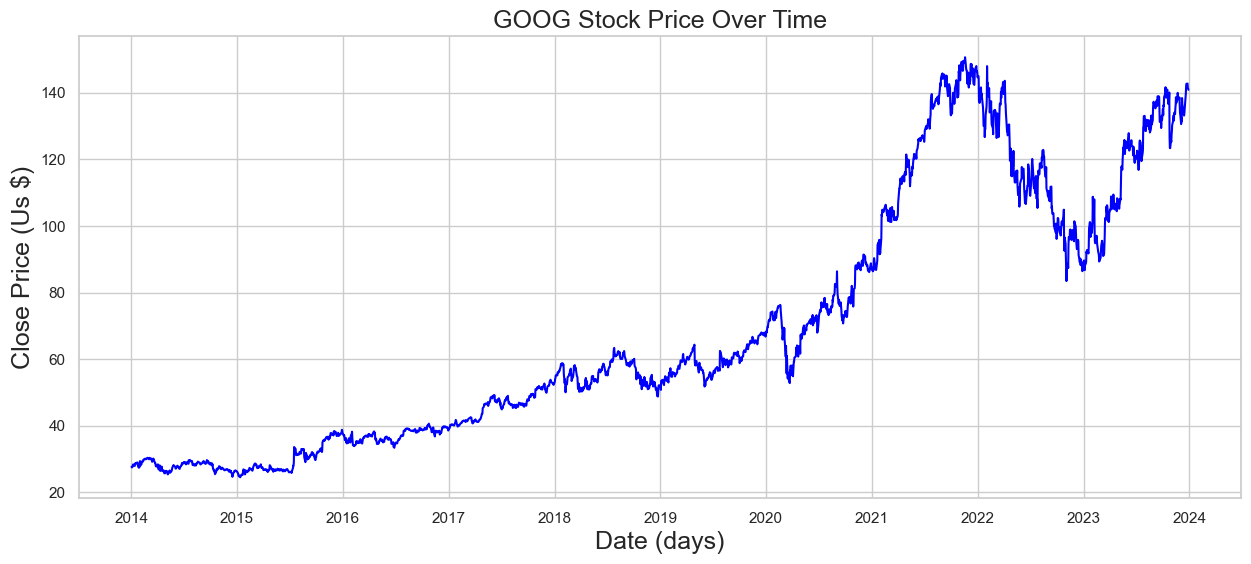

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(google_data['Date'], google_data['Close'], c = 'blue')
plt.title('GOOG Stock Price Over Time', fontsize=18)
plt.xlabel('Date (days)', fontsize=18)
plt.ylabel('Close Price (Us $)', fontsize=18)
plt.show()

### 2.5 Anomalies detection and removal

For outliers detection and removal in our data the Z-score method can be applied to this problem. It identifies anomalies based on how many standard deviations away a data point is from the mean. A common threshold for identifying an anomaly is a Z-score greater than 2 or less than -2, which corresponds to data points that are more than 2 standard deviations away from the mean.

In [ ]:
def detect_anomalies(df, column, period):
    df_copy = df.copy()
    rolling_mean = df_copy[column].rolling(window=period).mean()
    rolling_std = df_copy[column].rolling(window=period).std()
    df_copy['Z-score'] = (df_copy[column] - rolling_mean) / rolling_std
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies, df_copy['Z-score']

#### 2.5.1 Anomaly detection for Close Price

In [ ]:
anomalies_close = detect_anomalies(google_data, 'Close', 14)[0]

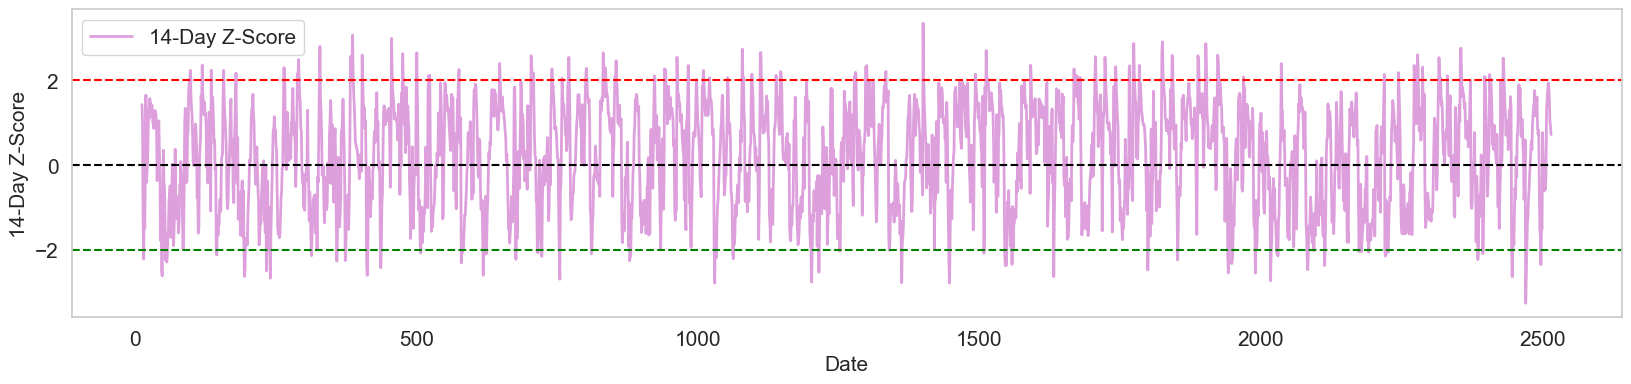

In [ ]:
fig = plt.figure(figsize = (20, 4))
plt.tick_params(axis = 'both', labelsize = 15)
detect_anomalies(google_data, 'Close', 14)[1].plot(lw = 2., c = 'plum', label = '14-Day Z-Score')
plt.axhline(y = 2 , color='red', linestyle='--')
plt.axhline(y = 0.0 , color='black', linestyle='--')
plt.axhline(y = -2 , color='green', linestyle='--')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('14-Day Z-Score', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 15)
plt.grid()

#### 2.5.1 Anomaly detection for Trading Volume

In [ ]:
anomalies_volume = detect_anomalies(google_data, 'Volume', 14)[0]

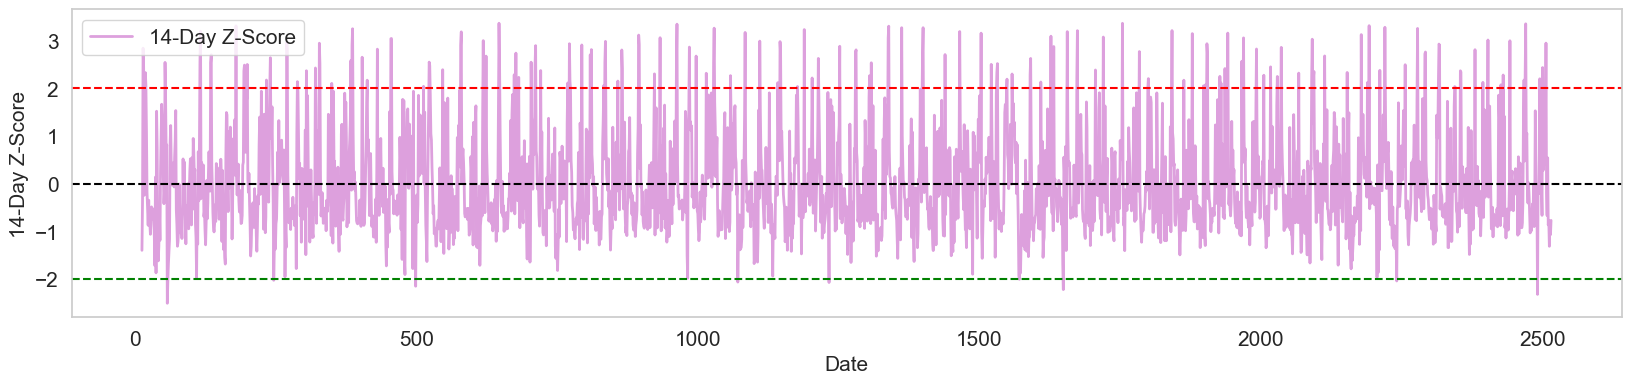

In [ ]:
fig = plt.figure(figsize = (20, 4))
plt.tick_params(axis = 'both', labelsize = 15)
detect_anomalies(google_data, 'Volume', 14)[1].plot(lw = 2., c = 'plum', label = '14-Day Z-Score')
plt.axhline(y = 2 , color='red', linestyle='--')
plt.axhline(y = 0.0 , color='black', linestyle='--')
plt.axhline(y = -2 , color='green', linestyle='--')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('14-Day Z-Score', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 15)
plt.grid()

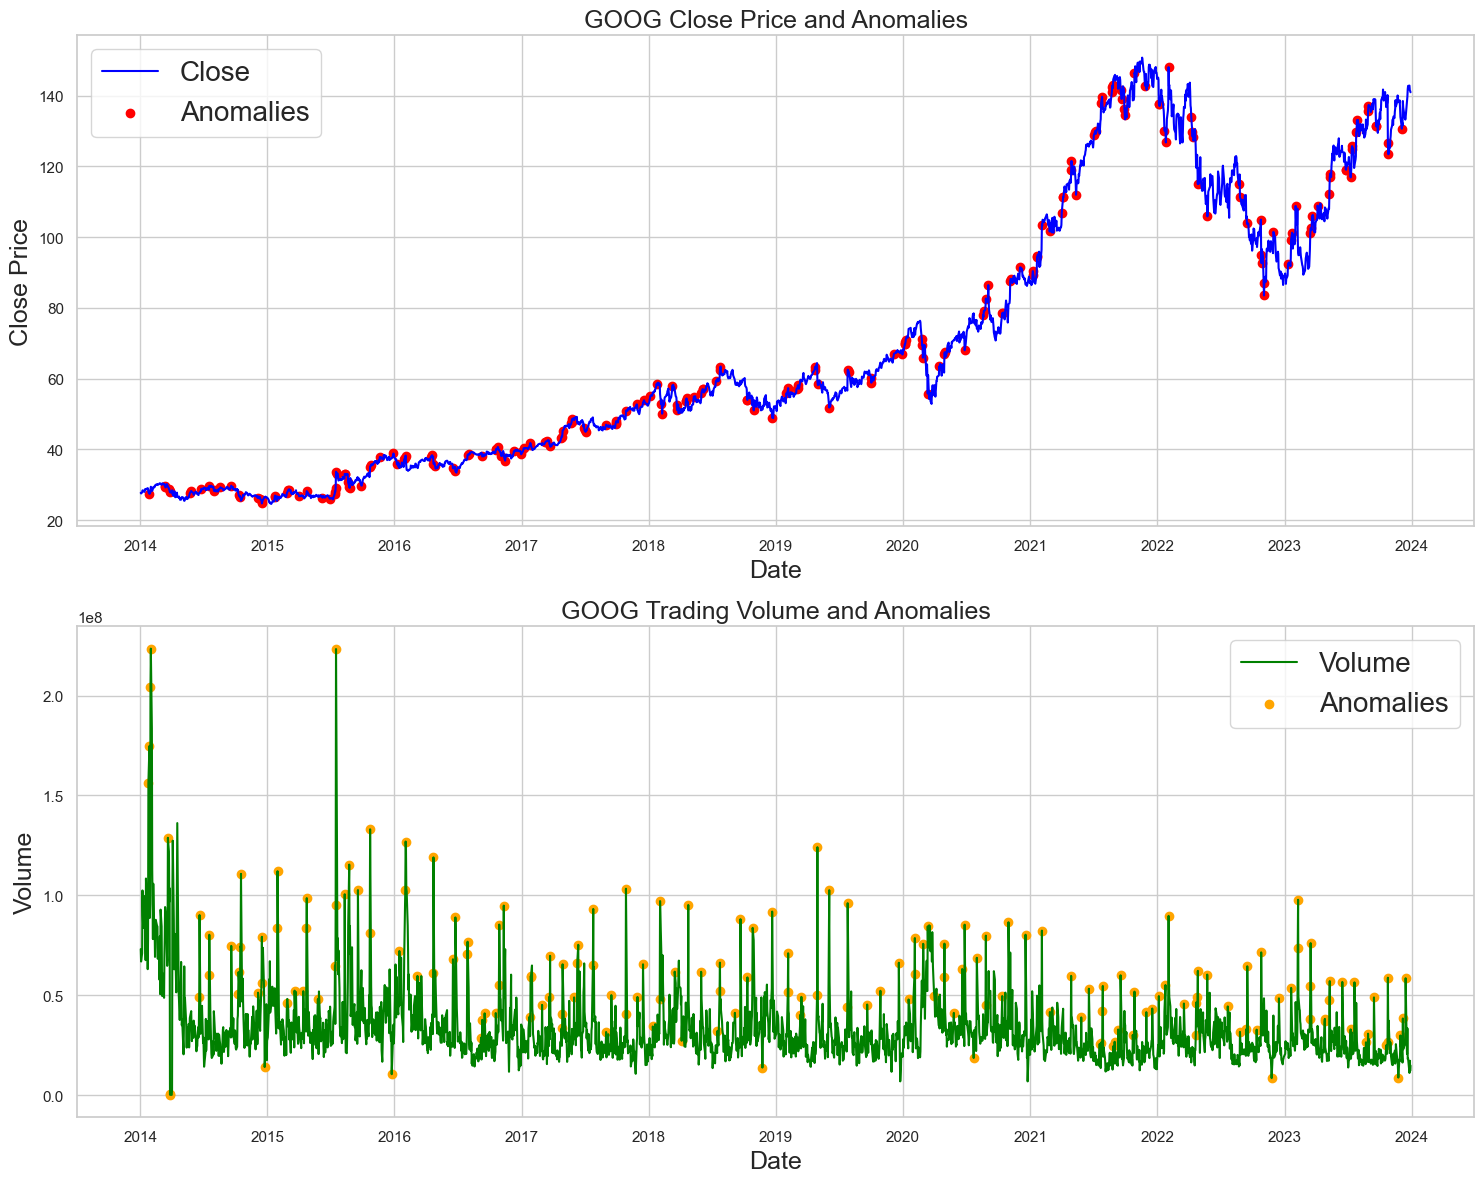

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

ax1.plot(google_data['Date'], google_data['Close'], label='Close', color='blue')
ax1.scatter(anomalies_close['Date'], anomalies_close['Close'], color='red', label='Anomalies')
ax1.set_title('GOOG Close Price and Anomalies', fontsize=18)
ax1.set_xlabel('Date', fontsize=18)
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(prop={'size': 20})

ax2.plot(google_data['Date'], google_data['Volume'], label='Volume', color='green')
ax2.scatter(anomalies_volume['Date'], anomalies_volume['Volume'], color='orange', label='Anomalies')
ax2.set_title('GOOG Trading Volume and Anomalies', fontsize=18)
ax2.set_xlabel('Date', fontsize=18)
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(prop={'size': 20})

plt.tight_layout()
plt.show()

The above charts for each company display the Close Prices and Trading Volumes over time, with anomalies highlighted. Anomalies are marked in red and represent significant deviations from 14-day prices range.

Anomalies in trading volume are marked in yellow and indicate days with exceptionally high or low trading activity compared to the norm.

These could correspond to days with unexpected news, earnings reports, or market shifts. For example Alphabet shares fell the most on Wednesday since the start of the Covid pandemic after revenue in the company's Google Cloud unit trailed analyst estimates. It marked its steepest drop since a 12% slump on March 16, 2020, the early days of the pandemic shutdowns.

In [ ]:
for index in anomalies_close.index:
    google_data.loc[index, google_data.columns != 'Date'] = np.nan

In [ ]:
google_data = google_data.ffill().bfill()

In order to remove detected anomalies they are replaced with NaN values. Then, Pandas dataframe.bfill() function is used to backward fill the missing values in the dataset.

In [ ]:
google_data.head(5)

,Date,Open,High,Low,Close,Volume
0,2014-01-02,27.782366,27.839401,27.603037,27.724083,73129082.0
1,2014-01-03,27.770908,27.818977,27.520098,27.521841,66917888.0
2,2014-01-06,27.721344,27.867046,27.557707,27.828691,71037271.0
3,2014-01-07,28.019974,28.385853,27.924334,28.365179,102486711.0
4,2014-01-08,28.543015,28.575891,28.226450,28.424210,90036218.0


### 2.6 Convert date

Dates are first converted to timestamps, and then to sin and cos, so that model can take advantage of periodicity. Based on: https://www.tensorflow.org/tutorials/structured_data/time_series#time

In [ ]:
data = google_data.copy()
timestamp_s = data['Date'].map(pd.Timestamp.timestamp)
data = data.drop(['Date'], axis=1)
day = 24*60*60
year = (365.2425)*day

data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

### 2.7 Splitting dataset into training, validation and testing sets

In [ ]:
dates = google_data['Date']

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, train_df = dates[:q_80], data[:q_80]
dates_val, val_df = dates[q_80:q_90], data[q_80:q_90]
dates_test, test_df = dates[q_90:], data[q_90:]

In [ ]:
train_df.head(5)

,Open,High,Low,Close,Volume,Day sin,Year sin,Year cos
0,27.782366,27.839401,27.603037,27.724083,73129082.0,-6.380772e-12,0.022878,0.999738
1,27.770908,27.818977,27.520098,27.521841,66917888.0,-2.082233e-12,0.040072,0.999197
2,27.721344,27.867046,27.557707,27.828691,71037271.0,-3.738532e-12,0.091562,0.995799
3,28.019974,28.385853,27.924334,28.365179,102486711.0,5.600062e-13,0.108678,0.994077
4,28.543015,28.575891,28.226450,28.424210,90036218.0,-9.693370e-12,0.125762,0.992060


### 2.8 Data normalization

Data normalization is necessary, because LSTM is sensitive to the scale of input features. For example 'High - Low' variable has different scale than '7 Days MA' variable. To achieve data normalization, a MinMaxScaler object is used. It is applied to different columns of DataFrame 'data'. Reshaping is also required to ensure it is in the right format for the scaler (since it expects a 2D array). Finally, each column is transformed separately and the original data is overwritten with the scaled values. This process will scale each column independently to a range between 0 and 1. It is essential to fit the scaler on the training data.

In [ ]:
def create_scalers(df=train_df):
    scalers = {}
    for col in df.columns:
        if col in ['Day sin', 'Year sin', 'Year cos']:
            continue
        scalers[col] = MinMaxScaler()
        df[col] = scalers[col].fit_transform(df[col].values.reshape(-1, 1))
    return scalers

In [ ]:
def apply_scaling(scalers, df):
    for col, scaler in scalers.items():
        df[col] = scaler.transform(df[col].values.reshape(-1, 1))

In [ ]:
scalers = create_scalers()

In [ ]:
apply_scaling(scalers, val_df)
apply_scaling(scalers, test_df)

In [ ]:
test_df.head()

,Open,High,Low,Close,Volume,Day sin,Year sin,Year cos
2264,0.493649,0.508453,0.499129,0.510428,0.081146,-9.636247e-12,-0.049051,0.998796
2265,0.496300,0.504244,0.499448,0.508684,0.085219,-5.337709e-12,-0.031863,0.999492
2266,0.515812,0.525642,0.515294,0.516373,0.092152,-2.695469e-12,0.036935,0.999318
2267,0.525152,0.523203,0.505579,0.508525,0.120397,-1.294885e-11,0.054119,0.998534
2268,0.501881,0.499367,0.495705,0.493147,0.102887,-8.650307e-12,0.071288,0.997456


### 2.9 Create windows

Based on https://www.tensorflow.org/tutorials/structured_data/time_series
The class WindowGenerator is used to prepare datasets for training with different input and label width, as well as for plotting sample results.

In [ ]:
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length][:, 3])
    return np.array(X), np.array(y)

seq_length = 7  # Number of time steps to look back
pred_length = 7
X_train, y_train = create_sequences(np.array(train_df), seq_length, pred_length)
X_test, y_test = create_sequences(np.array(test_df), seq_length, pred_length)
X_val, y_val = create_sequences(np.array(val_df), seq_length, pred_length)

In [ ]:
NUM_FEATURES=8

### 2.10 Helper functions

In [ ]:
def get_model_size(model):
    import shutil
    tf.saved_model.save(model, 'model')
    size = sum(os.path.getsize(os.path.join(dirpath, filename)) for dirpath, _, filenames in os.walk('model') for filename in filenames)
    shutil.rmtree('model')
    return size

def evaluate_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test, plot_interval=10, compiled=False, show_plot=True):
    import logging
    tf.get_logger().setLevel(logging.ERROR)

    metrics = {}
    metrics['name'] = name

    if not compiled:
        model.compile(loss='mse',
                  optimizer=AdamW(learning_rate=0.001))

    # Train
    start_time = time.time()
    model.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_val, y_val), verbose=0)
    metrics["training_time"] = time.time() - start_time

    metrics["model_size"] = get_model_size(model)

    # Predict
    test_predictions = model.predict(X_test, verbose=0)

    # Show
    test_predictions_org = scalers['Close'].inverse_transform(np.array(test_predictions[plot_interval]).reshape(-1, 1))
    y_test_org = scalers['Close'].inverse_transform(np.array(y_test[plot_interval]).reshape(-1, 1))
    x_test_org = scalers['Close'].inverse_transform(np.array(X_test[plot_interval][:, 3]).reshape(-1, 1))

    # Show
    if show_plot:
        plt.figure(figsize=(20, 8))
        plt.scatter(dates_test[plot_interval+seq_length:plot_interval+seq_length+pred_length], test_predictions_org)
        plt.scatter(dates_test[plot_interval+seq_length:plot_interval+seq_length+pred_length], y_test_org, linewidth = 3, c = 'gold')
        plt.plot(dates_test[plot_interval:plot_interval+seq_length], x_test_org, c = 'blue')
        plt.title(f'Classic LSTM Prediction Results for Testing Set in Relation to the GOOG Closing Price', fontsize=18)
        plt.xlabel('Date (days)', fontsize=18)
        plt.ylabel('Close Price (US $)', fontsize=18)
        plt.legend(['Prediction', 'Close Price'], prop={'size': 15})
        plt.grid()
        plt.show()

    # Metrics
    metrics["rmse"] = mean_squared_error(test_predictions_org, y_test_org)
    metrics["nrmse"] = mean_squared_error(y_test_org, test_predictions_org, squared=False)
    metrics["mae"] = mean_absolute_error(y_test_org, test_predictions_org)
    metrics["mape"] = mean_absolute_percentage_error(y_test_org, test_predictions_org)
    metrics["r2"] = r2_score(y_test_org, test_predictions_org)

    return metrics

## 3. Classic LSTM

### 3.1 Model building

In [ ]:
def classic_model_builder(neurons_num):
    model_classic = Sequential([
        layers.Input((X_train.shape[1], NUM_FEATURES)),
        layers.LSTM(neurons_num),
        layers.Dense(neurons_num // 2, activation='relu'),
        layers.Dense(neurons_num // 2, activation='relu'),
        layers.Dense(pred_length)])

    return model_classic

In [ ]:
neurons = [64, 128, 256]

for n in neurons:
    metrics = evaluate_model('Classic', classic_model_builder(n), X_train, y_train, X_val, y_val, X_test, y_test, show_plot=False)
    print(str(n))
    print(metrics)

C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


64
{'name': 'Classic', 'training_time': 19.044938802719116, 'model_size': 955535, 'rmse': 7.59219947463141, 'nrmse': 2.7553946132326326, 'mae': 2.3784582955496774, 'mape': 0.023674830207797926, 'r2': -1.7745102376924806}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


128
{'name': 'Classic', 'training_time': 23.10409641265869, 'model_size': 1689861, 'rmse': 1.391651042080161, 'nrmse': 1.179682602262219, 'mae': 0.9615576607840443, 'mape': 0.009674474853261806, 'r2': 0.4914319524337486}
256
{'name': 'Classic', 'training_time': 42.96340274810791, 'model_size': 4558333, 'rmse': 4.331783947277047, 'nrmse': 2.0812938157014367, 'mae': 1.6978988647460815, 'mape': 0.01721942019742628, 'r2': -0.5830167462473839}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 3.2 Model evaluation

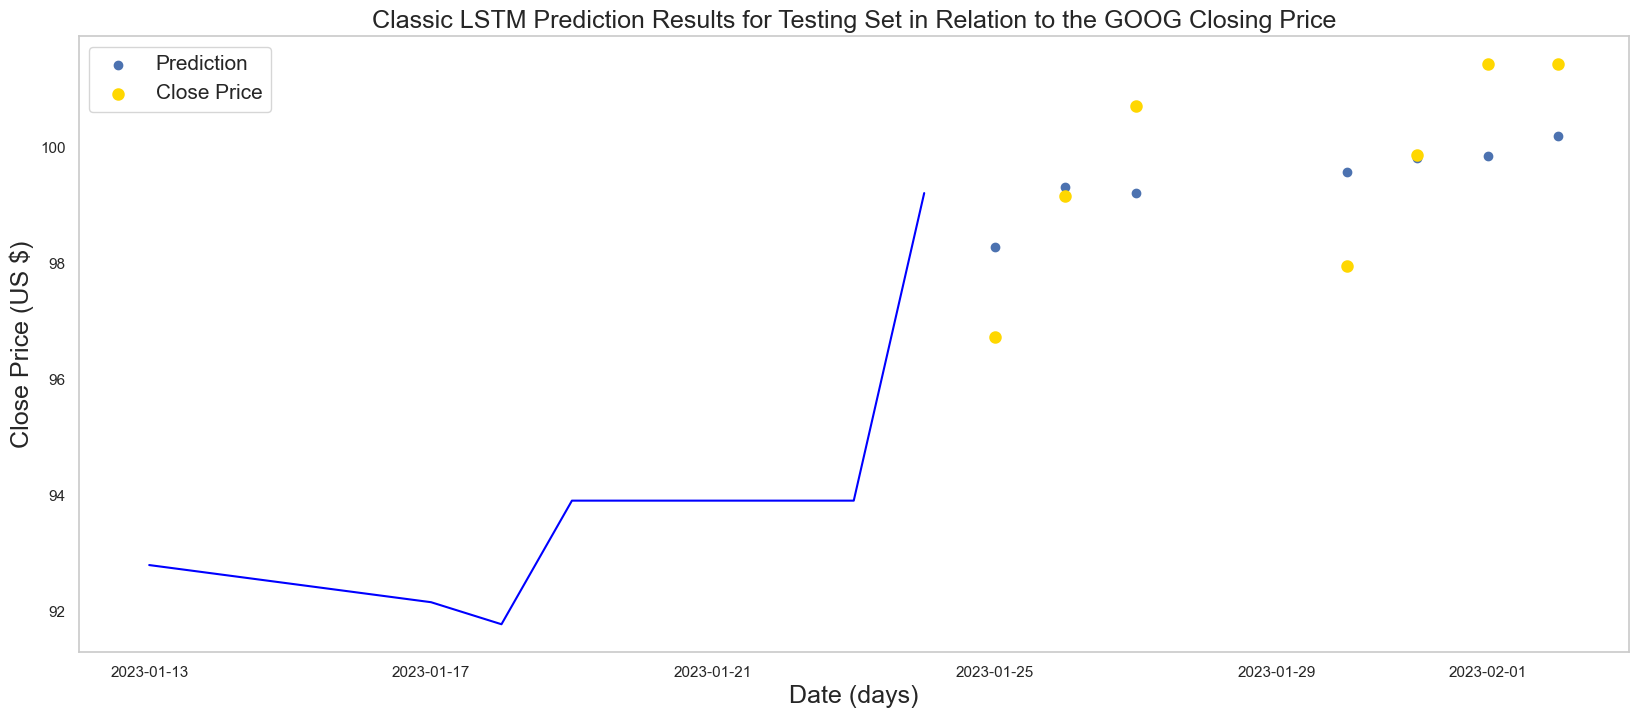

C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
classic_metrics = evaluate_model('Classic', classic_model_builder(128), X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
make_table([
    ['Training time [s]', 'Model size [kB]', 'RMSE', 'NRSME', 'MAE','MAPE [%]', 'R^2'],
    [
        classic_metrics['training_time'],
        classic_metrics['model_size'] / 1024,
        classic_metrics['rmse'],
        classic_metrics['nrmse'],
        classic_metrics['mae'],
        classic_metrics['mape'],
        classic_metrics['r2']
    ]
])

Training time [s],Model size [kB],RMSE,NRSME,MAE,MAPE [%],R^2
21.6475,1651.5195,1.6198,1.2727,1.0993,0.0110,0.4080


## 4. Bidirectional LSTM

### 4.1 Model building

In [ ]:
def blstm_model_builder(layers_num, neurons_num, learning_rate):
    model_blstm = Sequential()
    model_blstm.add(layers.Input((X_train.shape[1], X_train.shape[2])))
    for i in range(1, layers_num):
        model_blstm.add(layers.Bidirectional(layers.LSTM(neurons_num, activation='relu', return_sequences=True)))
    model_blstm.add(layers.Bidirectional(layers.LSTM(neurons_num, activation='relu', return_sequences=False)))

    model_blstm.add(layers.Dense(pred_length))

    model_blstm.compile(loss='mse',
                  optimizer=AdamW(learning_rate=learning_rate))

    return model_blstm

In [ ]:
layer_nums = [1, 2, 3]
neurons = [32, 64, 128]
learning_rates = [0.001]

results = []

for l in layer_nums:
    for n in neurons:
        for lr in learning_rates:
            metrics = evaluate_model('Bidirectional', blstm_model_builder(l, n, lr), X_train, y_train, X_val, y_val, X_test, y_test, compiled=True, show_plot=False)
            results.append((metrics, (l, n, lr)))
            print(f"layers_num: {l}, neurons_num: {n}, learning_rate: {lr}")
            print(metrics)

C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 1, neurons_num: 32, learning_rate: 0.001
{'name': 'Bidirectional', 'training_time': 16.359221935272217, 'model_size': 944696, 'rmse': 2.00155246177957, 'nrmse': 1.4147623340263091, 'mae': 1.0771353585379546, 'mape': 0.010737493288673584, 'r2': 0.2685482230752887}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 1, neurons_num: 64, learning_rate: 0.001
{'name': 'Bidirectional', 'training_time': 17.80682682991028, 'model_size': 1274893, 'rmse': 7.2400622644512245, 'nrmse': 2.6907363795903945, 'mae': 2.4311839512416418, 'mape': 0.02423879584573275, 'r2': -1.645824433534941}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 1, neurons_num: 128, learning_rate: 0.001
{'name': 'Bidirectional', 'training_time': 24.383368492126465, 'model_size': 2522473, 'rmse': 4.101328154842945, 'nrmse': 2.0251736110375687, 'mae': 1.6730150495256777, 'mape': 0.016667159304424643, 'r2': -0.49879846963591623}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 2, neurons_num: 32, learning_rate: 0.001
{'name': 'Bidirectional', 'training_time': 34.46182060241699, 'model_size': 2005536, 'rmse': 3.0598522839552436, 'nrmse': 1.749243346122901, 'mae': 1.4497517177036912, 'mape': 0.014537465027798995, 'r2': -0.11819921434199387}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 2, neurons_num: 64, learning_rate: 0.001
{'name': 'Bidirectional', 'training_time': 37.29462933540344, 'model_size': 3232362, 'rmse': 2.4363305864639733, 'nrmse': 1.5608749426087836, 'mae': 1.4602301461356109, 'mape': 0.014604447284927853, 'r2': 0.10966193958229897}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 2, neurons_num: 128, learning_rate: 0.001
{'name': 'Bidirectional', 'training_time': 58.368170976638794, 'model_size': 8028399, 'rmse': 2.914898923215702, 'nrmse': 1.7073075069288783, 'mae': 1.373929704938612, 'mape': 0.013916835271125009, 'r2': -0.06522713626322174}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 3, neurons_num: 32, learning_rate: 0.001
{'name': 'Bidirectional', 'training_time': 51.91658806800842, 'model_size': 3084500, 'rmse': 1.4720170253089615, 'nrmse': 1.213267087375637, 'mae': 1.0961478097098296, 'mape': 0.011034801252693726, 'r2': 0.462062829036032}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 3, neurons_num: 64, learning_rate: 0.001
{'name': 'Bidirectional', 'training_time': 55.45804715156555, 'model_size': 5190096, 'rmse': 3.264961382665171, 'nrmse': 1.8069204140374227, 'mae': 1.528633117675769, 'mape': 0.015466134063251294, 'r2': -0.19315473890586876}
layers_num: 3, neurons_num: 128, learning_rate: 0.001
{'name': 'Bidirectional', 'training_time': 85.37781000137329, 'model_size': 13531679, 'rmse': 2.331113444932252, 'nrmse': 1.5267984296993014, 'mae': 1.2433199201311342, 'mape': 0.012592126680854047, 'r2': 0.14811272546272014}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 4.2 Model evaluation

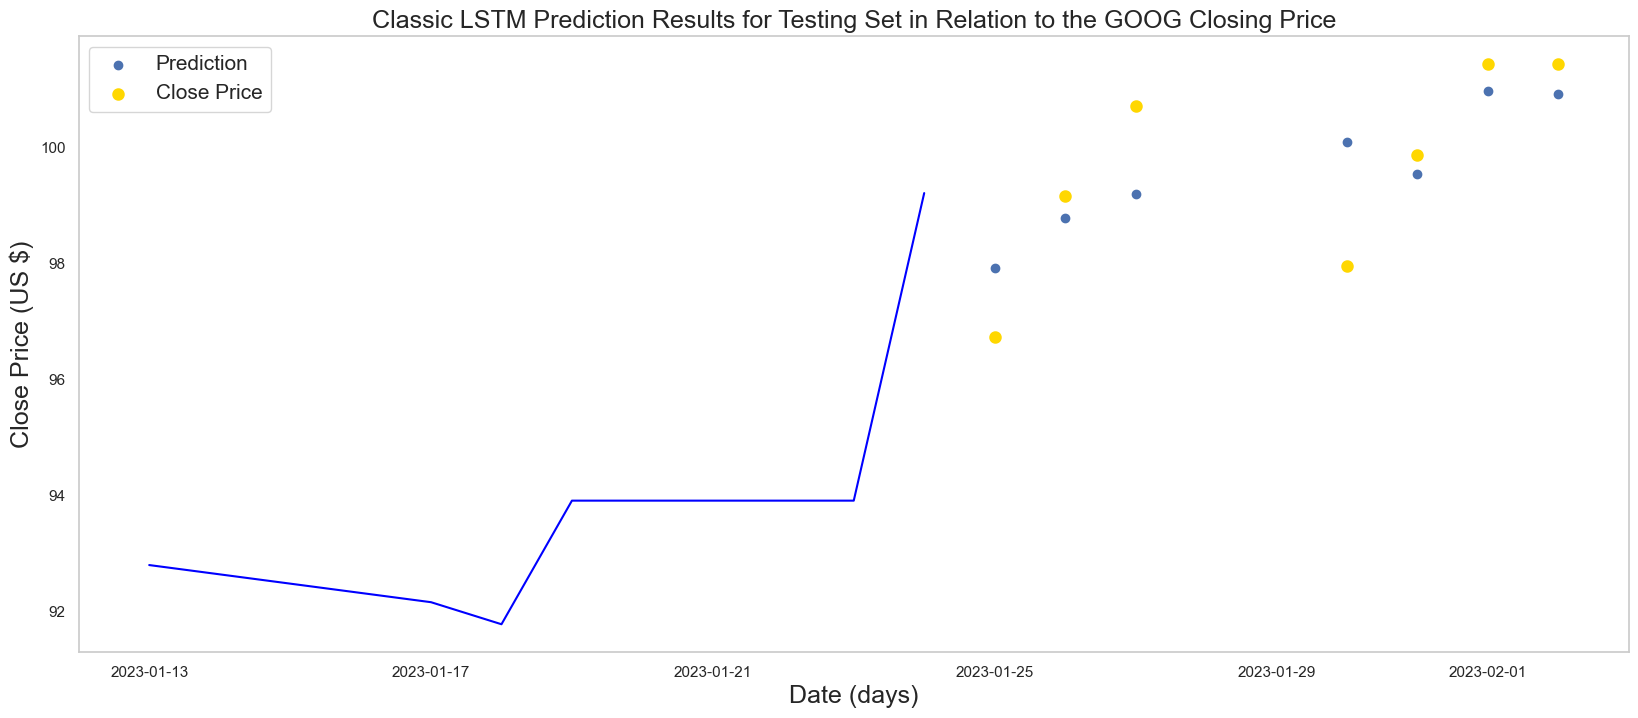

{'name': 'Bidirectional', 'training_time': 46.49069690704346, 'model_size': 3085590, 'rmse': 1.2861073993761798, 'nrmse': 1.1340667526103478, 'mae': 0.9318073817661912, 'mape': 0.009409667112479038, 'r2': 0.5300020556276942}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# blstm_metrics = evaluate_model('Bidirectional', blstm_model_builder(*best_params), X_train, y_train, X_val, y_val, X_test, y_test, compiled=True)
blstm_metrics = evaluate_model('Bidirectional', blstm_model_builder(3, 32, 0.001), X_train, y_train, X_val, y_val, X_test, y_test, compiled=True)
print(blstm_metrics)

In [ ]:
make_table([
    ['Training time [s]', 'Model size [kB]', 'RMSE', 'NRSME', 'MAE','MAPE [%]', 'R^2'],
    [
        blstm_metrics['training_time'],
        blstm_metrics['model_size'] / 1024,
        blstm_metrics['rmse'],
        blstm_metrics['nrmse'],
        blstm_metrics['mae'],
        blstm_metrics['mape'],
        blstm_metrics['r2']
    ]
])

Training time [s],Model size [kB],RMSE,NRSME,MAE,MAPE [%],R^2
46.4907,3013.2715,1.2861,1.1341,0.9318,0.0094,0.5300


## 5. Stacked LSTM

### 5.1 Model building

In [ ]:
def stack_model_builder(layers_num, neurons_num):
    model = Sequential()
    model.add(layers.Input((X_train.shape[1], X_train.shape[2])))
    for i in range(1, layers_num):
        model.add(layers.LSTM(neurons_num, activation='relu', return_sequences=True))
    model.add(layers.LSTM(neurons_num, activation='relu', return_sequences=False))
    model.add(layers.Dense(pred_length))
    model.compile(loss='mse', optimizer=AdamW(learning_rate=0.001))
    return model

In [ ]:
layer_nums = [1, 2, 3]
neurons = [32, 64, 128]

for l in layer_nums:
    for n in neurons:
        metrics = evaluate_model('Stacked', stack_model_builder(l, n), X_train, y_train, X_val, y_val, X_test, y_test, compiled=True, show_plot=False)
        print(str(l) + ', ' + str(n))
        print(metrics)

C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1, 32
{'name': 'Stacked', 'training_time': 13.355479001998901, 'model_size': 334322, 'rmse': 1.041523861848493, 'nrmse': 1.0205507639742832, 'mae': 0.7850559779575933, 'mape': 0.007861578140307964, 'r2': 0.6193832067827822}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1, 64
{'name': 'Stacked', 'training_time': 15.217789649963379, 'model_size': 498288, 'rmse': 4.5257320342602565, 'nrmse': 2.1273767964938077, 'mae': 1.8459548950195395, 'mape': 0.018397140552323738, 'r2': -0.6538935658981095}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1, 128
{'name': 'Stacked', 'training_time': 19.851614475250244, 'model_size': 1121805, 'rmse': 4.724680715564887, 'nrmse': 2.17363306829025, 'mae': 1.8647144862583827, 'mape': 0.018597134477494556, 'r2': -0.7265978138435858}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2, 32
{'name': 'Stacked', 'training_time': 22.918951272964478, 'model_size': 651227, 'rmse': 11.209023405989116, 'nrmse': 3.34798796383576, 'mae': 3.153676714215972, 'mape': 0.03148719083093771, 'r2': -3.0962504078518407}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2, 64
{'name': 'Stacked', 'training_time': 26.87511420249939, 'model_size': 1111642, 'rmse': 2.027377492082993, 'nrmse': 1.4238600675919642, 'mae': 1.2999747140067046, 'mape': 0.0130362449439621, 'r2': 0.2591106666458268}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2, 128
{'name': 'Stacked', 'training_time': 37.80667281150818, 'model_size': 2918673, 'rmse': 1.8767743477365215, 'nrmse': 1.369954140742135, 'mae': 1.209843226841526, 'mape': 0.01209246952840405, 'r2': 0.31414741419364445}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3, 32
{'name': 'Stacked', 'training_time': 30.18570637702942, 'model_size': 968296, 'rmse': 8.2165168087398, 'nrmse': 2.8664467217689222, 'mae': 2.5222385951451014, 'mape': 0.025105726402654478, 'r2': -2.0026621508291806}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3, 64
{'name': 'Stacked', 'training_time': 34.644766330718994, 'model_size': 1725162, 'rmse': 2.140800752361035, 'nrmse': 1.4631475497573834, 'mae': 1.1370609828403977, 'mape': 0.011517507889038528, 'r2': 0.21766101850560005}
3, 128
{'name': 'Stacked', 'training_time': 52.51197695732117, 'model_size': 4715703, 'rmse': 1.4366715527056588, 'nrmse': 1.1986123446326, 'mae': 0.9760796683175305, 'mape': 0.009783070524685281, 'r2': 0.4749795570437222}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 5.2 Model evaluation

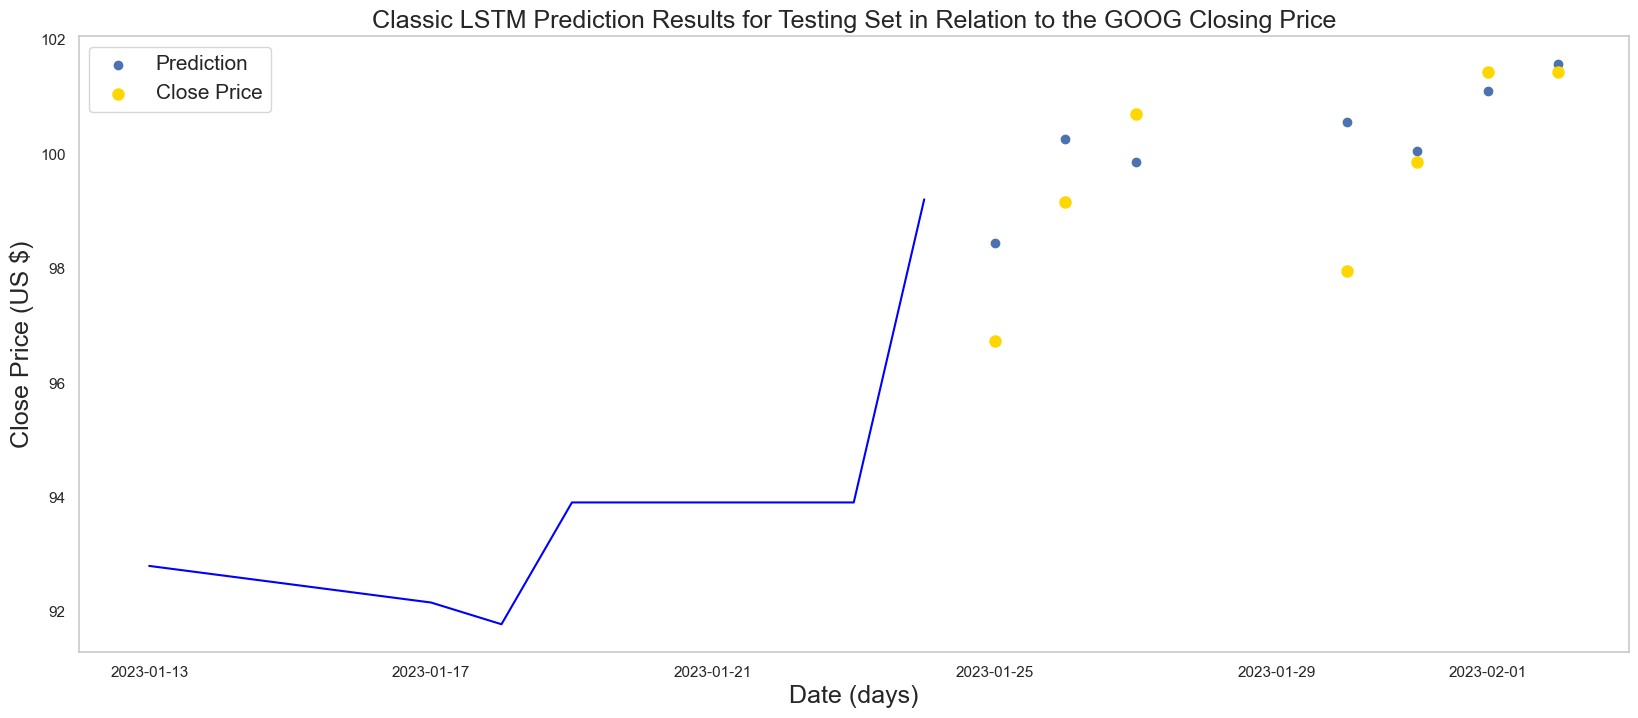

C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
stacked_metrics = evaluate_model('Stacked', stack_model_builder(3, 128), X_train, y_train, X_val, y_val, X_test, y_test, compiled=True)

In [ ]:
make_table([
    ['Training time [s]', 'Model size [kB]', 'RMSE', 'NRSME', 'MAE','MAPE [%]', 'R^2'],
    [
        stacked_metrics['training_time'],
        stacked_metrics['model_size'] / 1024,
        stacked_metrics['rmse'],
        stacked_metrics['nrmse'],
        stacked_metrics['mae'],
        stacked_metrics['mape'],
        stacked_metrics['r2']
    ]
])

Training time [s],Model size [kB],RMSE,NRSME,MAE,MAPE [%],R^2
53.1827,4605.9531,1.6905,1.3002,0.9895,0.0101,0.3822


## 6. GRU

### 6.1 Model building

In [ ]:
def gru_model_builder(layers_num, neurons_num, learning_rate):
    model_gru = Sequential()
    model_gru.add(layers.Input((X_train.shape[1], X_train.shape[2])))
    for i in range(1, layers_num):
        model_gru.add(layers.GRU(neurons_num, activation='relu', return_sequences=True))
    model_gru.add(layers.GRU(neurons_num, activation='relu', return_sequences=False))
    model_gru.add(layers.Dense(pred_length))

    model_gru.compile(loss='mse',
                  optimizer=AdamW(learning_rate=learning_rate))

    return model_gru

In [ ]:
layer_nums = [1, 2, 3]
neurons = [32, 64, 128]
learning_rates = [0.001]

results = []

for l in layer_nums:
    for n in neurons:
        for lr in learning_rates:
            metrics = evaluate_model('GRU', gru_model_builder(l, n, lr), X_train, y_train, X_val, y_val, X_test, y_test, compiled=True, show_plot=False)
            results.append((metrics, (l, n, lr)))
            print(f"layers_num: {l}, neurons_num: {n}, learning_rate: {lr}")
            print(metrics)

C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 1, neurons_num: 32, learning_rate: 0.001
{'name': 'GRU', 'training_time': 13.940492630004883, 'model_size': 322117, 'rmse': 4.95383813336962, 'nrmse': 2.2257219353211264, 'mae': 1.8121250697544764, 'mape': 0.018022408058446397, 'r2': -0.8103416095469085}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 1, neurons_num: 64, learning_rate: 0.001
{'name': 'GRU', 'training_time': 14.961401224136353, 'model_size': 448457, 'rmse': 2.0624092430558387, 'nrmse': 1.4361090637746976, 'mae': 1.210986546107705, 'mape': 0.01210167168381795, 'r2': 0.2463085857675219}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 1, neurons_num: 128, learning_rate: 0.001
{'name': 'GRU', 'training_time': 19.220409154891968, 'model_size': 920171, 'rmse': 3.077713097595366, 'nrmse': 1.754341214700084, 'mae': 1.3729378836495616, 'mape': 0.013750952870725554, 'r2': -0.1247263097461151}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 2, neurons_num: 32, learning_rate: 0.001
{'name': 'GRU', 'training_time': 24.641745805740356, 'model_size': 620186, 'rmse': 5.203727735422733, 'nrmse': 2.2811680638266734, 'mae': 1.973148890904026, 'mape': 0.019636312773412896, 'r2': -0.9016618207065239}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 2, neurons_num: 64, learning_rate: 0.001
{'name': 'GRU', 'training_time': 25.497445821762085, 'model_size': 969226, 'rmse': 1.9127641695667918, 'nrmse': 1.3830271760044313, 'mae': 1.0600640433175224, 'mape': 0.010741634836234899, 'r2': 0.30099521377340177}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 2, neurons_num: 128, learning_rate: 0.001
{'name': 'GRU', 'training_time': 33.19920301437378, 'model_size': 2330714, 'rmse': 1.9519162470990206, 'nrmse': 1.3971099624220782, 'mae': 1.1431808471679605, 'mape': 0.011561377011037228, 'r2': 0.28668739160631207}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 3, neurons_num: 32, learning_rate: 0.001
{'name': 'GRU', 'training_time': 32.95361042022705, 'model_size': 918134, 'rmse': 4.109237358157037, 'nrmse': 2.0271253928055453, 'mae': 1.616400582449789, 'mape': 0.01604476925265916, 'r2': -0.5016888264607415}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


layers_num: 3, neurons_num: 64, learning_rate: 0.001
{'name': 'GRU', 'training_time': 35.90038871765137, 'model_size': 1491614, 'rmse': 1.9222939758328785, 'nrmse': 1.3864681661808462, 'mae': 1.152988978794647, 'mape': 0.011614201683538883, 'r2': 0.2975126202065663}
layers_num: 3, neurons_num: 128, learning_rate: 0.001
{'name': 'GRU', 'training_time': 45.97402858734131, 'model_size': 3743199, 'rmse': 5.34109325025094, 'nrmse': 2.311080537378769, 'mae': 2.034112112862715, 'mape': 0.020513143832713156, 'r2': -0.9518609795234436}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 6.2 Model evaluation

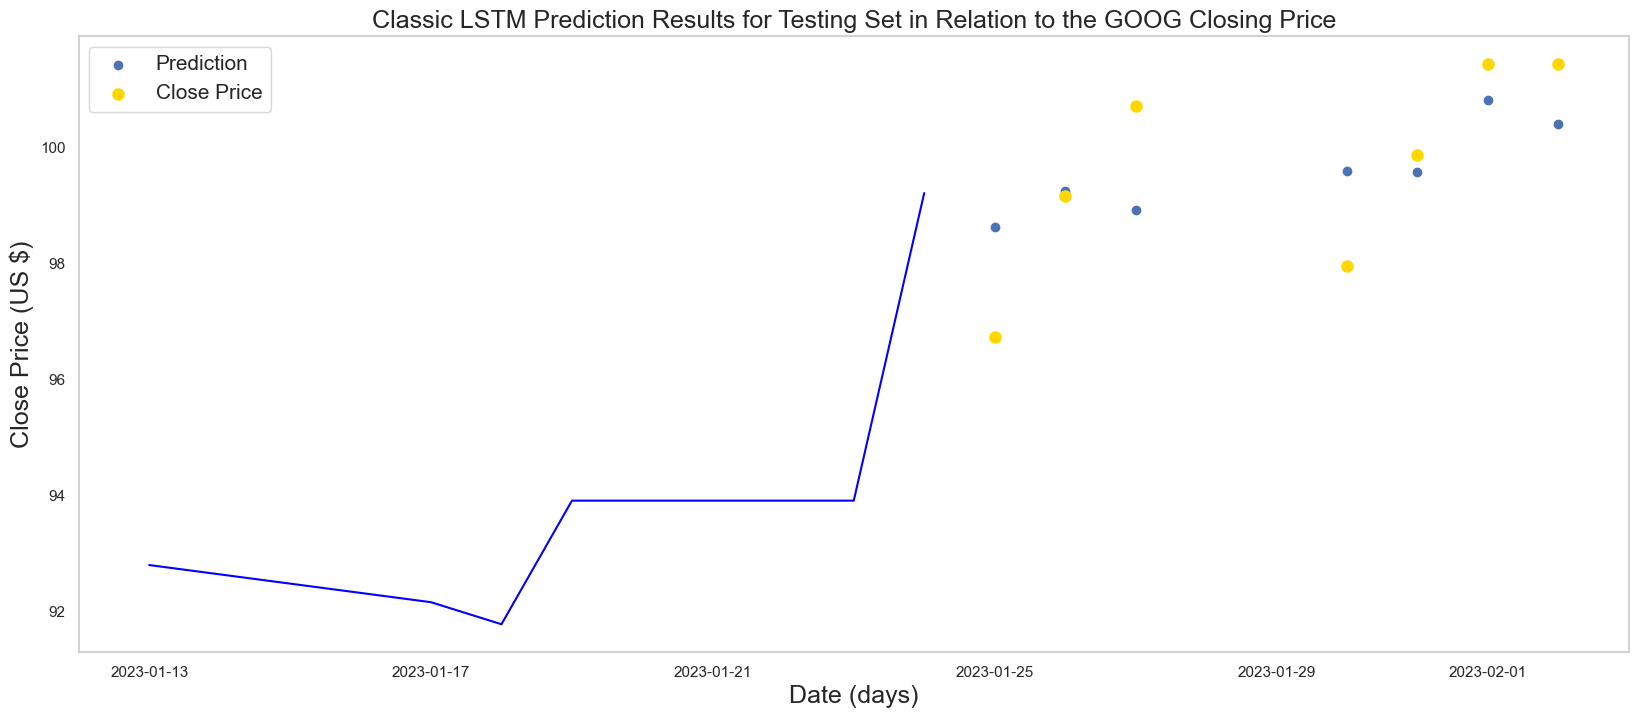

C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
gru_metrics = evaluate_model('GRU', gru_model_builder(2, 64, 0.001), X_train, y_train, X_val, y_val, X_test, y_test)

### 6.3 Performance evaluation

In [ ]:
make_table([
    ['Training time [s]', 'Model size [kB]', 'RMSE', 'NRSME', 'MAE','MAPE [%]', 'R^2'],
    [
        gru_metrics['training_time'],
        gru_metrics['model_size'] / 1024,
        gru_metrics['rmse'],
        gru_metrics['nrmse'],
        gru_metrics['mae'],
        gru_metrics['mape'],
        gru_metrics['r2']
    ]
])

Training time [s],Model size [kB],RMSE,NRSME,MAE,MAPE [%],R^2
23.5198,947.6514,1.5730,1.2542,1.0518,0.0106,0.4252


## 7. Bidirectional GRU

### 7.1 Model building

In [ ]:
def bigru_model_builder(layers_num, neurons_num):
    model_bigru = Sequential()
    model_bigru.add(layers.Input((X_train.shape[1], X_train.shape[2])))
    for i in range(1, layers_num):
        model_bigru.add(layers.Bidirectional(layers.GRU(neurons_num, activation='relu', return_sequences=True)))
    model_bigru.add(layers.Bidirectional(layers.GRU(neurons_num, activation='relu', return_sequences=False)))
    model_bigru.add(layers.Dense(pred_length))

    model_bigru.compile(loss='mse',
                  optimizer=AdamW(learning_rate=0.001))

    return model_bigru

In [ ]:
layer_nums = [1, 2, 3]
neurons = [32, 64, 128]

for l in layer_nums:
    for n in neurons:
        metrics = evaluate_model('Bidirectional GRU', bigru_model_builder(l, n), X_train, y_train, X_val, y_val, X_test, y_test, compiled=True, show_plot=False)
        print(str(l) + ', ' + str(n))
        print(metrics)

C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1, 32
{'name': 'Bidirectional GRU', 'training_time': 16.47049832344055, 'model_size': 942906, 'rmse': 1.9926419742073025, 'nrmse': 1.4116097102978933, 'mae': 1.221226283482147, 'mape': 0.012201268141955301, 'r2': 0.2718044914431964}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1, 64
{'name': 'Bidirectional GRU', 'training_time': 18.3549382686615, 'model_size': 1193690, 'rmse': 4.029466523572663, 'nrmse': 2.007353113822444, 'mae': 1.793731689453121, 'mape': 0.018076374128880655, 'r2': -0.47253719550542295}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1, 128
{'name': 'Bidirectional GRU', 'training_time': 22.68139147758484, 'model_size': 2137040, 'rmse': 2.926337801186105, 'nrmse': 1.710654202691504, 'mae': 1.3416944231305803, 'mape': 0.013616681568476886, 'r2': -0.06940738523358214}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2, 32
{'name': 'Bidirectional GRU', 'training_time': 33.998841524124146, 'model_size': 1954170, 'rmse': 4.453993864598586, 'nrmse': 2.1104487353637817, 'mae': 1.8529717581612641, 'mape': 0.01867158845095483, 'r2': -0.6276774098520665}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2, 64
{'name': 'Bidirectional GRU', 'training_time': 35.675461292266846, 'model_size': 2874644, 'rmse': 4.94987336714982, 'nrmse': 2.224831087329962, 'mae': 1.9214728219168487, 'mape': 0.019348251030550816, 'r2': -0.808892716574108}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2, 128
{'name': 'Bidirectional GRU', 'training_time': 49.554290533065796, 'model_size': 6483232, 'rmse': 2.9352123154593097, 'nrmse': 1.7132461339396945, 'mae': 1.4288112095424026, 'mape': 0.014460189045500893, 'r2': -0.07265050743918633}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3, 32
{'name': 'Bidirectional GRU', 'training_time': 53.676369428634644, 'model_size': 2965578, 'rmse': 5.39334625888811, 'nrmse': 2.322357909299966, 'mae': 1.8979622977120414, 'mape': 0.01919083365397114, 'r2': -0.9709564350496702}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3, 64
{'name': 'Bidirectional GRU', 'training_time': 54.80216431617737, 'model_size': 4555752, 'rmse': 3.7719596360277525, 'nrmse': 1.9421533502861592, 'mae': 1.6362064906528937, 'mape': 0.01648685909474679, 'r2': -0.3784333066182879}
3, 128
{'name': 'Bidirectional GRU', 'training_time': 78.04528164863586, 'model_size': 10829572, 'rmse': 3.882411028998541, 'nrmse': 1.9703834725754632, 'mae': 1.743025643484925, 'mape': 0.017554702265603496, 'r2': -0.4187969089694663}


C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 7.2 Model evaluation

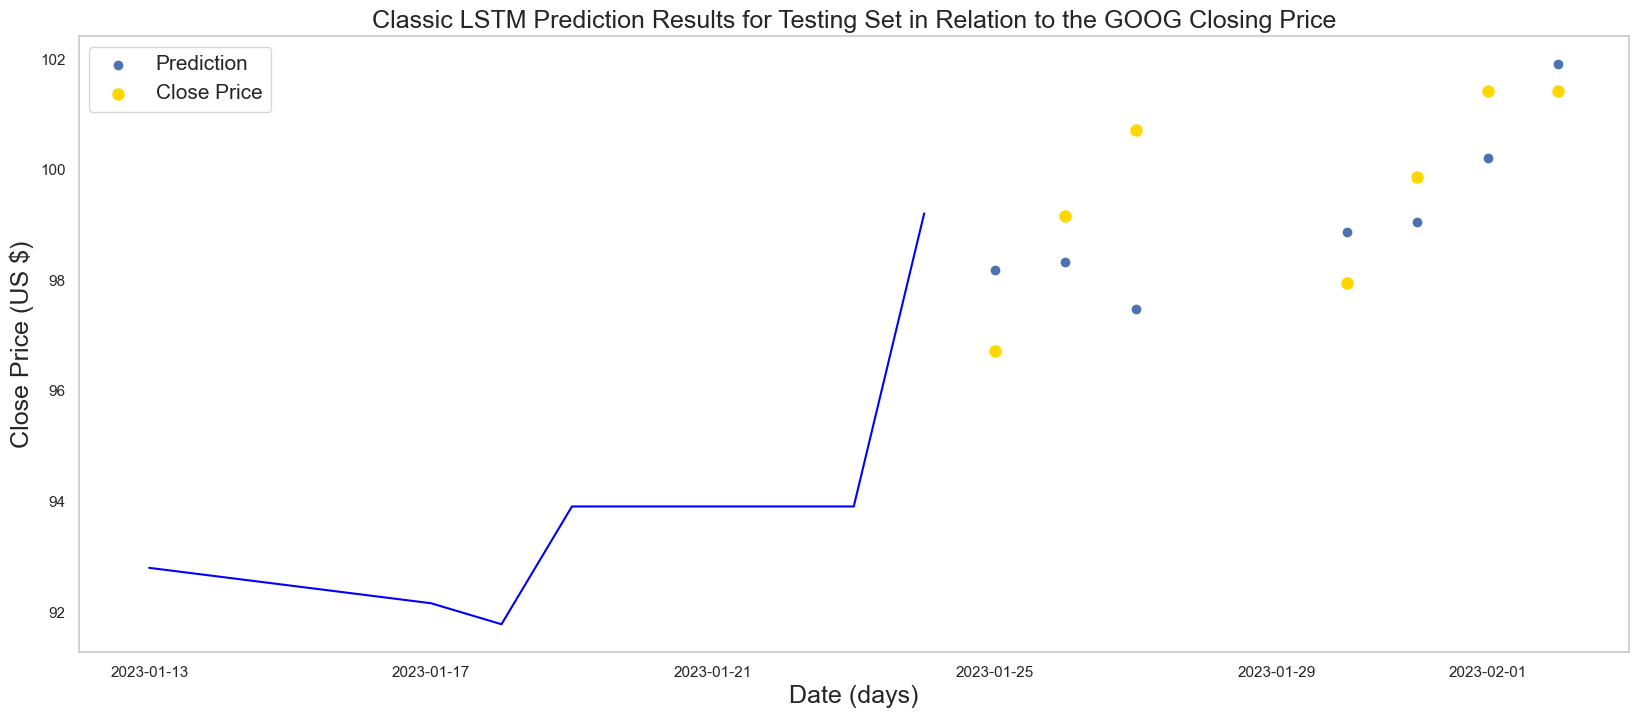

C:\Users\Bartek\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
bigru_metrics = evaluate_model('Bidirectional GRU', bigru_model_builder(1, 32), X_train, y_train, X_val, y_val, X_test, y_test, compiled=True)

In [ ]:
make_table([
    ['Training time [s]', 'Model size [kB]', 'RMSE', 'NRSME', 'MAE','MAPE [%]', 'R^2'],
    [
        bigru_metrics['training_time'],
        bigru_metrics['model_size'] / 1024,
        bigru_metrics['rmse'],
        bigru_metrics['nrmse'],
        bigru_metrics['mae'],
        bigru_metrics['mape'],
        bigru_metrics['r2']
    ]
])

Training time [s],Model size [kB],RMSE,NRSME,MAE,MAPE [%],R^2
16.5378,920.8047,2.3528,1.5339,1.2785,0.0128,0.1402


## 8. Comparision of LSTM variants by chosen criteria

In [ ]:
models_metrics = [
    classic_metrics,
    blstm_metrics,
    stacked_metrics,
    gru_metrics,
    bigru_metrics
]

In [ ]:
header = ['Training time [s]', 'Model size [kB]', 'RMSE', 'NRSME', 'MAE','MAPE [%]', 'R^2']
row_names = ['LSTM Variant']

lstm_variants_results = []

for metrics in models_metrics:
    lstm_variants_results.append([
        metrics['training_time'],
        metrics['model_size'] / 1024,
        metrics['rmse'],
        metrics['nrmse'],
        metrics['mae'],
        metrics['mape'],
        metrics['r2']
    ])

    row_names.append(metrics['name'],)

lstm_variants_results = np.array(lstm_variants_results).astype(np.float64)
row_names.extend(['Average', 'Median', 'St-Dev', 'Min', 'Max'])

summary = [ [] for _ in range(5) ]

for i in range(7):
    summary[0].append(lstm_variants_results[:, i].mean())
    summary[1].append(np.median(lstm_variants_results[:, i]))
    summary[2].append(lstm_variants_results[:, i].std())
    summary[3].append(lstm_variants_results[:, i].min())
    summary[4].append(lstm_variants_results[:, i].max())

lstm_variants_results = np.around(np.vstack([lstm_variants_results, summary]), decimals=3)
lstm_variants_results = np.vstack([header, lstm_variants_results])
lstm_variants_results = np.hstack([np.array(row_names).reshape((11, 1)), lstm_variants_results])

make_table(lstm_variants_results)

LSTM Variant,Training time [s],Model size [kB],RMSE,NRSME,MAE,MAPE [%],R^2
Classic,21.648,1651.52,1.62,1.273,1.099,0.011,0.408
Bidirectional,46.491,3013.271,1.286,1.134,0.932,0.009,0.53
Stacked,53.183,4605.953,1.69,1.3,0.989,0.01,0.382
GRU,23.52,947.651,1.573,1.254,1.052,0.011,0.425
Bidirectional GRU,16.538,920.805,2.353,1.534,1.278,0.013,0.14
Average,32.276,2227.84,1.704,1.299,1.07,0.011,0.377
Median,23.52,1651.52,1.62,1.273,1.052,0.011,0.408
St-Dev,14.673,1410.794,0.352,0.13,0.119,0.001,0.129
Min,16.538,920.805,1.286,1.134,0.932,0.009,0.14
Max,53.183,4605.953,2.353,1.534,1.278,0.013,0.53


Text(0.5, 0, 'Typ modelu')

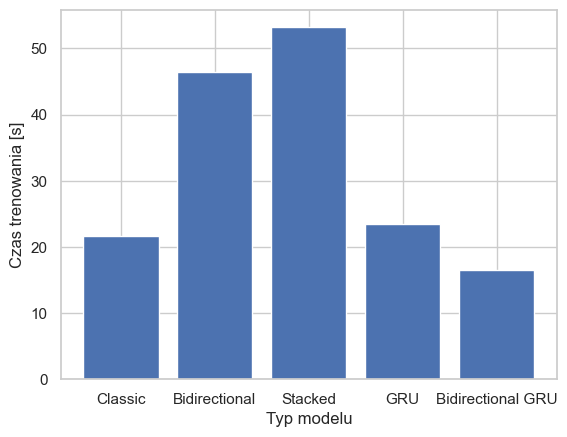

In [ ]:
plt.bar(lstm_variants_results[1:6][:, 0], lstm_variants_results[1:6][:, 1].astype(np.float64))
plt.ylabel('Czas trenowania [s]')
plt.xlabel('Typ modelu')

Text(0.5, 0, 'Typ modelu')

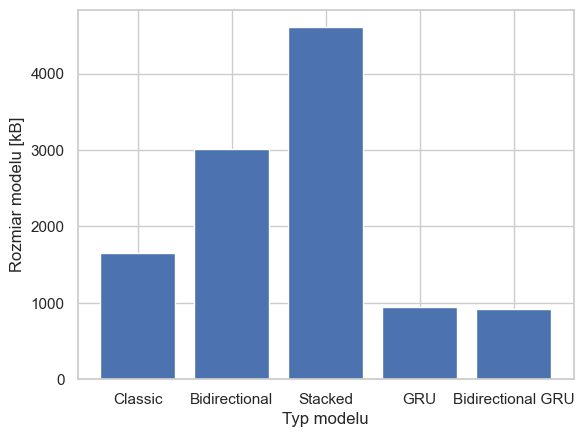

In [ ]:
plt.bar(lstm_variants_results[1:6][:, 0], lstm_variants_results[1:6][:, 2].astype(np.float64))
plt.ylabel('Rozmiar modelu [kB]')
plt.xlabel('Typ modelu')

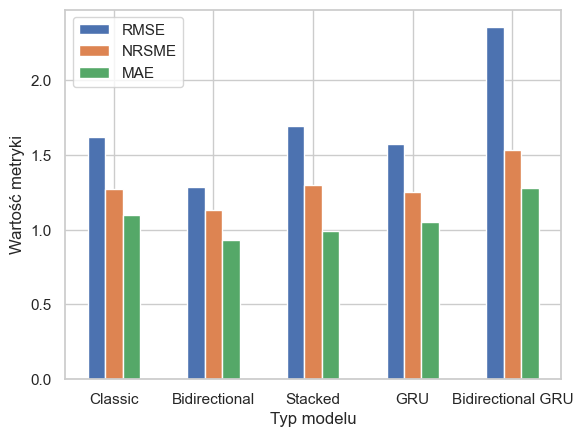

In [ ]:
N = 5
ind = np.array([0, 2, 4, 6, 8])  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(3, 6):
    bar = plt.bar(ind + (i - 3) * width, lstm_variants_results[1:6][:, i].astype(np.float64), width)
    bar.set_label(lstm_variants_results[0][i])

# add some
ax.set_ylabel('Wartość metryki')
ax.set_xlabel('Typ modelu')
ax.set_xticks(ind + width)
ax.set_xticklabels(lstm_variants_results[1:6][:, 0])

ax.legend()

plt.show()

Text(0.5, 0, 'Typ modelu')

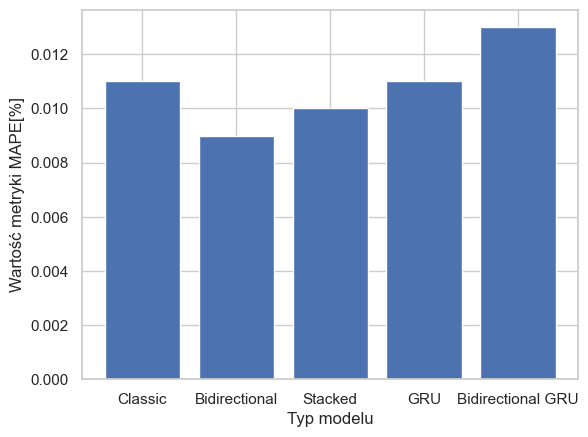

In [ ]:
plt.bar(lstm_variants_results[1:6][:, 0], lstm_variants_results[1:6][:, 6].astype(np.float64))
plt.ylabel('Wartość metryki MAPE[%]')
plt.xlabel('Typ modelu')

Text(0.5, 0, 'Typ modelu')

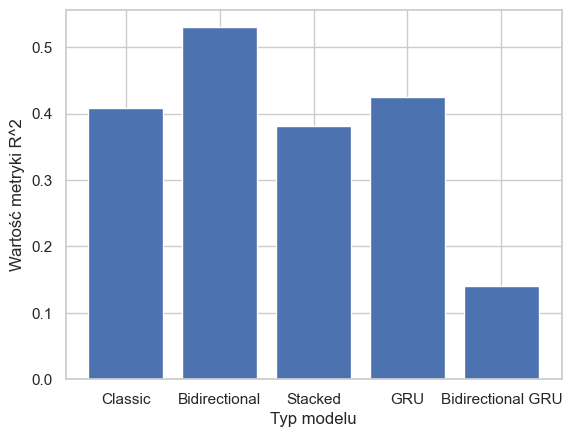

In [ ]:
plt.bar(lstm_variants_results[1:6][:, 0], lstm_variants_results[1:6][:, 7].astype(np.float64))
plt.ylabel('Wartość metryki R^2')
plt.xlabel('Typ modelu')

## 9.Summary

The above study compared the performance of various LSTM model variants in terms of training time, model size, and different error metrics. Here are the key findings:

**Bidirectional LSTM** performed the best in terms of RMSE (1.286), NRMSE (1.134), MAE (0.932), MAPE (0.009%), and R^2 (0.53). Despite having a higher training time and larger model size compared to other models, it provided the most accurate predictions, making it suitable for applications where accuracy is a priority.

**Classic LSTM** achieved a good balance between training time, model size, and prediction accuracy. It had a moderate training time (21.648 s) and model size (1651.52 kB) while maintaining respectable error metrics (RMSE: 1.62, R^2: 0.408).

**Stacked LSTM** had the highest training time (53.183 s) and largest model size (4605.953 kB), but did not significantly outperform other models in terms of accuracy (RMSE: 1.69, R^2: 0.382). It may be better suited for tasks where model complexity can be justified by slight improvements in prediction accuracy.

**GRU** offered a good compromise between training time, model size, and performance. With a training time of 23.52 s and model size of 947.651 kB, it achieved decent accuracy (RMSE: 1.573, R^2: 0.425), making it an efficient alternative to LSTM models.

**Bidirectional GRU** had the shortest training time (16.538 s) and one of the smallest model sizes (920.805 kB), yet had the highest RMSE (2.353) and lowest R^2 (0.14). It might be more suitable for scenarios where training time and model size are critical factors, and slight reductions in accuracy are acceptable.

In summary, the choice of model depends on the trade-off between prediction accuracy and computational resources. The Bidirectional LSTM provides the best accuracy but at the cost of higher training time and model size. The Classic LSTM and GRU offer a good balance of efficiency and accuracy, while the Bidirectional GRU is optimal for scenarios requiring quick training and smaller models.